### Imports

In [13]:
# Data management
import numpy as np
import pandas as pd

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Deep learning
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# Visualization
import matplotlib.pyplot as plt

### Data Extraction and Feature Engineering

In [6]:
# Load data from saved file
df = pd.read_csv('pair_trade.csv')
df

,Date,Asset1,Asset2,Spread,ZScore
0,2017-05-25,53.630291,52.344387,-1.673399,1.204262
1,2017-05-26,53.620483,52.295151,-1.631186,1.238759
2,2017-05-30,53.532246,52.255764,-1.677811,1.156256
3,2017-05-31,53.571461,52.373917,-1.763428,1.019630
4,2017-06-01,54.061672,52.856403,-1.782981,0.973343
...,...,...,...,...,...
1259,2022-05-25,92.930000,86.949997,1.064264,0.255584
1260,2022-05-26,95.080002,89.040001,1.006103,0.216648
1261,2022-05-27,97.660004,91.400002,1.092681,0.238969
1262,2022-05-31,96.480003,90.540001,0.821301,0.083033


In [7]:
df.drop(columns=['Date'], inplace=True)
df['lrets_a1'] = np.log(df.Asset1 / df.Asset1.shift(1))
df['lrets_a2'] = np.log(df.Asset2 / df.Asset2.shift(1))
df['lrets_a1_roll'] = df.lrets_a1.rolling(window=21).mean()
df['lrets_a2_roll'] = df.lrets_a2.rolling(window=21).mean()
df['a1_prod_rets'] = df.lrets_a1.cumsum()
df['a2_prod_rets'] = df.lrets_a2.cumsum()

df.dropna(inplace=True)
print('Length: ', len(df))
df.head()

Length:  1243


,Asset1,Asset2,Spread,ZScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets
21,54.227489,53.271168,-2.055377,0.403727,-0.000543,0.000741,0.000527,0.000836,0.011074,0.017551
22,53.589405,52.501556,-1.880340,0.649103,-0.011837,-0.014552,-0.000028,0.000188,-0.000763,0.002998
23,54.256935,53.133030,-1.879984,0.634294,0.012379,0.011956,0.000640,0.000793,0.011617,0.014954
24,53.658115,52.521286,-1.832474,0.689018,-0.011098,-0.011580,0.000077,0.000134,0.000519,0.003374
25,53.932976,52.767960,-1.818233,0.694927,0.005109,0.004686,-0.000113,-0.000080,0.005628,0.008059


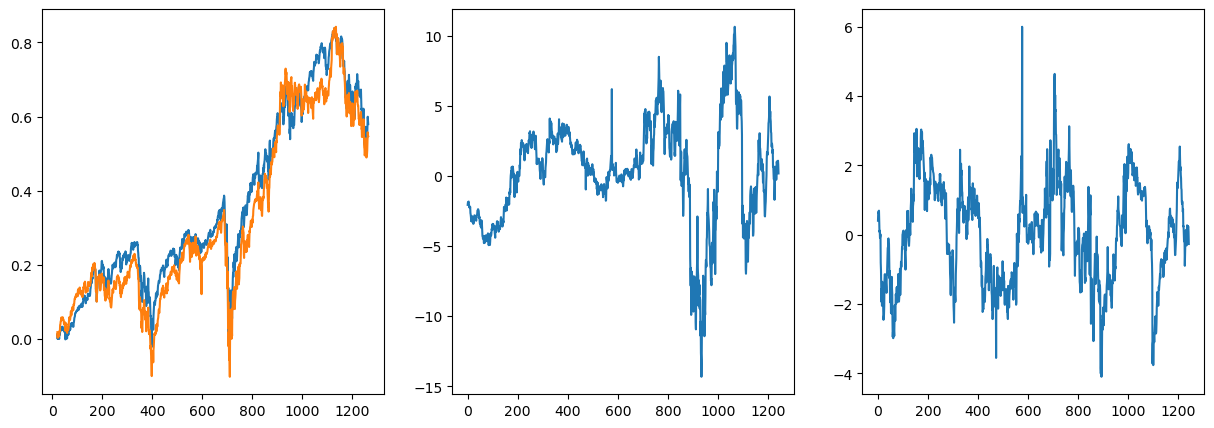

In [9]:
# Visualize data
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(df.a1_prod_rets, label='Asset 1')
plt.plot(df.a2_prod_rets, label='Asset 2')

plt.subplot(1, 3, 2)
plt.plot(df.Spread.values, label='Asset 1')

plt.subplot(1, 3, 3)
plt.plot(df.ZScore.values, label='Asset 1')

In [10]:
# Add target
future_step = 1
df['Target'] = 0
df.loc[df.Spread.shift(-future_step) > 0, 'Target'] = 1
df.dropna(inplace=True)
df.head()

,Asset1,Asset2,Spread,ZScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets,Target
21,54.227489,53.271168,-2.055377,0.403727,-0.000543,0.000741,0.000527,0.000836,0.011074,0.017551,0
22,53.589405,52.501556,-1.880340,0.649103,-0.011837,-0.014552,-0.000028,0.000188,-0.000763,0.002998,0
23,54.256935,53.133030,-1.879984,0.634294,0.012379,0.011956,0.000640,0.000793,0.011617,0.014954,0
24,53.658115,52.521286,-1.832474,0.689018,-0.011098,-0.011580,0.000077,0.000134,0.000519,0.003374,0
25,53.932976,52.767960,-1.818233,0.694927,0.005109,0.004686,-0.000113,-0.000080,0.005628,0.008059,0


In [11]:
# Split X and y
X_data = df.iloc[:, :-1].values
y_data = df.Target.values
len(X_data), len(y_data)

(1243, 1243)

In [12]:
# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X_data)
X[:2]

array([[-1.26492611, -1.13504476, -0.63395987,  0.25890302, -0.06874343,
         0.0197518 ,  0.02761802,  0.13117419, -1.46674999, -1.28742802],
       [-1.29718371, -1.17576153, -0.58682679,  0.42967168, -0.84531675,
        -0.94004753, -0.15727973, -0.06985924, -1.51634206, -1.34812881]])

### Dataload Structuring

In [15]:
# Dataset class
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = len(self.X)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
trainset = dataset(X, y_data)
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)

In [16]:
# Review X data
trainloader.dataset.X[:2]

tensor([[-1.2649, -1.1350, -0.6340,  0.2589, -0.0687,  0.0198,  0.0276,  0.1312,
         -1.4668, -1.2874],
        [-1.2972, -1.1758, -0.5868,  0.4297, -0.8453, -0.9400, -0.1573, -0.0699,
         -1.5163, -1.3481]])

In [17]:
# Review y data
trainloader.dataset.y[:2]

tensor([0., 0.])

### Build Neural Network

In [14]:
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

### Train Neural Network

In [18]:
# Hyperparameters
learning_rate = 0.01
epochs = 100

# Model, optimizer and loss function
model = Net(input_shape=X.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

In [22]:
# Forward loop
losses = []
accuracy = []

for i in range(epochs):
    for j, (X_train, y_train) in enumerate(trainloader):
        
        # Calculate output
        output = model(X_train)

        # Calculate loss
        loss = loss_fn(output, y_train.unsqueeze(1))

        # Calculate accuracy
        predicted = model(torch.tensor(X, dtype=torch.float32))
        acc = (predicted.detach().numpy().round() == y_data).mean()

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print results
        if i % 10 == 0 and j == 0:
            print(f'Epoch {i}, Loss: {loss.item()}, Accuracy: {acc}')
            losses.append(loss.item())
            accuracy.append(acc)

Epoch 0, Loss: 7.826740144878386e-09, Accuracy: 0.5189492372086582
Epoch 10, Loss: 2.0469536439124414e-13, Accuracy: 0.5127649673246609
Epoch 20, Loss: 1.0271606021251475e-14, Accuracy: 0.5210106605033239
Epoch 30, Loss: 3.048969132724011e-10, Accuracy: 0.5210106605033239
Epoch 40, Loss: 2.808197896442266e-09, Accuracy: 0.5210106605033239
Epoch 50, Loss: 3.7690972476411844e-06, Accuracy: 0.5225963707299898
Epoch 60, Loss: 4.9511600082041696e-06, Accuracy: 0.5260849332286549
Epoch 70, Loss: 3.1900543717711116e-07, Accuracy: 0.5286220695913204
Epoch 80, Loss: 1.3121730368936824e-08, Accuracy: 0.5211692315259905
Epoch 90, Loss: 1.5629620975232683e-07, Accuracy: 0.5211692315259905
